In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
train = pd.read_csv('C:\\Users\\user\\workspace\\movie\\movies_train.csv')
test = pd.read_csv('C:\\Users\\user\\workspace\\movie\movies_test.csv')
submission = pd.read_csv('C:\\Users\\user\\workspace\\movie\\submission.csv')

EDA 및 전처리

In [3]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [6]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [7]:
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num') #장르별 평균 관객수

,box_off_num
genre,
뮤지컬,6.627000e+03
다큐멘터리,6.717226e+04
서스펜스,8.261100e+04
애니메이션,1.819267e+05
멜로/로맨스,4.259680e+05
미스터리,5.275482e+05
공포,5.908325e+05
드라마,6.256898e+05
코미디,1.193914e+06


In [8]:
pd.reset_option('display.float.format')

In [9]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


<AxesSubplot:>

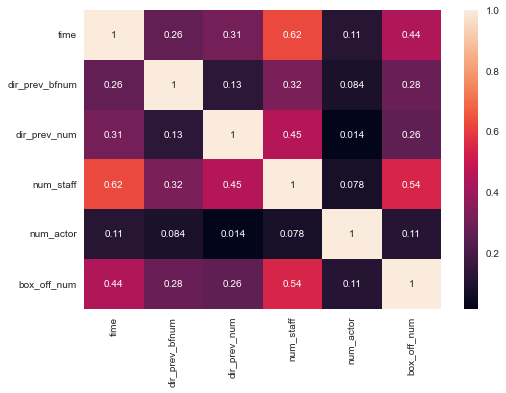

In [10]:
plt.style.use('seaborn')
sns.heatmap(train.corr(), annot=True)

In [11]:
train.isna().sum() / 600

title             0.00
distributor       0.00
genre             0.00
release_time      0.00
time              0.00
screening_rat     0.00
director          0.00
dir_prev_bfnum    0.55
dir_prev_num      0.00
num_staff         0.00
num_actor         0.00
box_off_num       0.00
dtype: float64

In [12]:
test.isna().sum() / 600

title             0.000000
distributor       0.000000
genre             0.000000
release_time      0.000000
time              0.000000
screening_rat     0.000000
director          0.000000
dir_prev_bfnum    0.226667
dir_prev_num      0.000000
num_staff         0.000000
num_actor         0.000000
dtype: float64

In [13]:
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


In [14]:
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

In [15]:
train['dir_prev_bfnum'].fillna(0, inplace=True)

In [16]:
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,0.00,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,0.00,0,431,4,2192525


In [17]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [18]:
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

In [19]:
test['dir_prev_bfnum'].fillna(0, inplace=True)

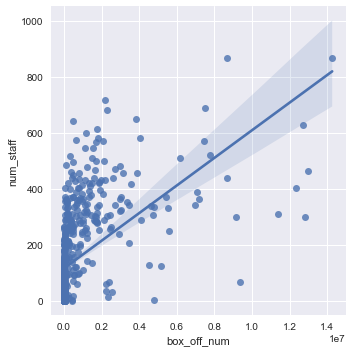

In [20]:
sns.lmplot(data=train, x='box_off_num', y='num_staff')

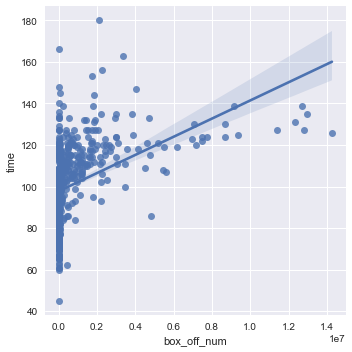

In [21]:
sns.lmplot(data=train, x="box_off_num", y="time")

모델링

singleLGBM

In [22]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

In [23]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

In [24]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [25]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

In [26]:
singleLGBM = submission.copy()

In [27]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [28]:
singleLGBM['box_off_num'] = model.predict(X_test)

In [29]:
singleLGBM.to_csv('singleLGBM', index = False)

KFold

In [30]:
from sklearn.model_selection import KFold

In [31]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=777)

In [32]:
for train_idx, val_idx in k_fold.split(X_train):
    print(len(train_idx), len(val_idx))
    break

480 120


In [33]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

[100]	valid_0's l2: 2.70572e+12
[100]	valid_0's l2: 3.90847e+12
[100]	valid_0's l2: 3.50344e+12
[100]	valid_0's l2: 1.45977e+12
[100]	valid_0's l2: 1.77214e+12


C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [34]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [40]:
kfoldLightGBM = submission.copy()

In [41]:
kfoldLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [43]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3.367422e+06
1,아빠가 여자를 좋아해,9.611389e+05
2,하모니,1.097930e+06
3,의형제,2.097271e+06
4,평행 이론,7.814763e+05


features 추가

In [44]:
features

['time', 'dir_prev_num', 'num_staff', 'num_actor']

In [45]:
train.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num'],
      dtype='object')

In [46]:
train.genre

0       액션
1      느와르
2       액션
3      코미디
4      코미디
      ... 
595    드라마
596    드라마
597     공포
598    느와르
599     액션
Name: genre, Length: 600, dtype: object

In [48]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])

In [49]:
train['genre']

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int32

In [50]:
test['genre'] = le.transform(test['genre'])

In [51]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor', 'dir_prev_bfnum', 'genre']

In [52]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [53]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 2.62067e+12
[100]	valid_0's l2: 4.39227e+12
[100]	valid_0's l2: 3.29841e+12
[100]	valid_0's l2: 1.56499e+12
[100]	valid_0's l2: 1.60118e+12


In [54]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [56]:
feLightGBM = submission.copy()

In [57]:
feLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [58]:
feLightGBM.to_csv('singleLGBM', index = False)

그리드서치

In [59]:
 from sklearn.model_selection import GridSearchCV

In [61]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

params = {
    'learning_rate': [0.1, 0.01, 0.003],
    'min_child_samples': [20, 30]}

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring='neg_mean_squared_error',
                  cv = k_fold)

In [62]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

In [63]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

In [64]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000, learning_rate=0.003, min_child_samples=30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 2.56673e+12
[200]	valid_0's l2: 2.45583e+12
[300]	valid_0's l2: 2.42575e+12
[400]	valid_0's l2: 2.43392e+12
[100]	valid_0's l2: 4.89194e+12
[200]	valid_0's l2: 4.40922e+12
[300]	valid_0's l2: 4.19146e+12
[400]	valid_0's l2: 4.05951e+12
[500]	valid_0's l2: 3.96931e+12
[600]	valid_0's l2: 3.91727e+12
[700]	valid_0's l2: 3.88462e+12
[800]	valid_0's l2: 3.87695e+12
[900]	valid_0's l2: 3.87088e+12
[100]	valid_0's l2: 3.14361e+12
[200]	valid_0's l2: 2.79286e+12
[300]	valid_0's l2: 2.59302e+12
[400]	valid_0's l2: 2.47608e+12
[500]	valid_0's l2: 2.40386e+12
[600]	valid_0's l2: 2.36407e+12
[700]	valid_0's l2: 2.38505e+12
[100]	valid_0's l2: 1.60592e+12
[200]	valid_0's l2: 1.40227e+12
[300]	valid_0's l2: 1.30053e+12
[400]	valid_0's l2: 1.25184e+12
[500]	valid_0's l2: 1.23543e+12
[600]	valid_0's l2: 1.23595e+12
[100]	valid_0's l2: 1.96107e+12
[200]	valid_0's l2: 1.75478e+12
[300]	valid_0's l2: 1.64513e+12
[400]	valid_0's l2: 1.58132e+12
[500]	valid_0's l2: 1.54801e+12
[600]	va

In [65]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [66]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

In [68]:
gslgbm = submission.copy()

In [69]:
gslgbm['box_off_num'] = np.mean(preds, axis = 0)

In [70]:
gslgbm.to_csv('gslgbm.csv', index = False)

In [72]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'gslgbm.csv', 
'33be24fb3c494aa72bbf8d20460949f1f514eb1885c039d97ef0aab8be546085', 
'235536', 
'rgm', 
'LGBMRegressor' )

{'isSubmitted': True, 'detail': 'Success'}
